# Using RNN

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pydotplus as pyd

import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, concatenate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
# from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
%matplotlib inline
import os
import re
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

# Data Pre-Processing


In [6]:
df1 = pd.read_json('/content/drive/MyDrive/sarcasm detection/Datasets/twitter/sarcasm_detection_shared_task_twitter_testing.jsonl',lines=True)
df = pd.read_json('/content/drive/MyDrive/sarcasm detection/Datasets/twitter/sarcasm_detection_shared_task_twitter_training.jsonl',lines=True)

df['labels'] = df['label'].apply(lambda x: ['SARCASM', 'NOT_SARCASM'].index(x))
df1['labels'] = df1['label'].apply(lambda x: ['SARCASM', 'NOT_SARCASM'].index(x))
df1.tail()
df3=pd.concat([df1,df])
# df3

- ### Filtering headlines 


In [ ]:
# df['response'] = df['response'].apply(lambda x: x.lower())
# df['response'] = df['response'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))


# df1['response'] = df1['response'].apply(lambda x: x.lower())
# df1['response'] = df1['response'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

- ### Defining Max features 
- ### using Tokenizer to vectorize and convert text into Sequences 
 so that the Network can deal with it as input

In [7]:
for idx,row in df.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 16000 #tunable
tokenizer = Tokenizer(num_words=max_fatures,split=' ',filters='"$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')#tunable
tokenizer.fit_on_texts(df3['response'].values)
X_train = tokenizer.texts_to_sequences(df['response'].values)
X_test = tokenizer.texts_to_sequences(df1['response'].values)

pad_len=max(max([len(X_train[i]) for i in range(len(X_train))]),max([len(X_test[i]) for i in range(len(X_test))])) #tunable
X_train = pad_sequences(X_train,pad_len)
X_test = pad_sequences(X_test,pad_len)

vocab_size = len(tokenizer.word_index)
print(vocab_size)

17082


In [ ]:
# tokenizer.word_index

### Splitting data to train & test

In [8]:
Y_train, Y_test = df['labels'],df1['labels']

Y_train, Y_test = pd.get_dummies(Y_train).values, pd.get_dummies(Y_test).values

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(5000, 69) (5000, 2)
(1800, 69) (1800, 2)


# Defining the LSTM RNN Model
With softmax activation

In [ ]:
embed_dim = 128  #tunable  
lstm_out = 196 #tunable

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              mode = 'max', 
                              factor=0.9, 
                              patience=4, 
                              min_lr=0.00001, 
                              verbose=10)

checkpoint = ModelCheckpoint("models/sentiment_model.h5", 
                               monitor="val_accuracy", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_accuracy', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 4,
                            verbose=1)

#### Training the model

In [ ]:
batch_size = 128
history=model.fit(X_train, Y_train, epochs = 25, batch_size=batch_size,validation_data=(X_test,Y_test), callbacks=[ earlystop, reduce_lr])

Epoch 1/25
40/40 [==============================] - 38s 886ms/step - loss: 0.6755 - accuracy: 0.5600 - val_loss: 0.6884 - val_accuracy: 0.5928
Epoch 2/25
40/40 [==============================] - 35s 880ms/step - loss: 0.4945 - accuracy: 0.7547 - val_loss: 0.6836 - val_accuracy: 0.6217
Epoch 3/25
40/40 [==============================] - 35s 876ms/step - loss: 0.2976 - accuracy: 0.8729 - val_loss: 0.8714 - val_accuracy: 0.6311
Epoch 4/25
40/40 [==============================] - 35s 872ms/step - loss: 0.1819 - accuracy: 0.9345 - val_loss: 0.8620 - val_accuracy: 0.6228
Epoch 5/25
40/40 [==============================] - 35s 877ms/step - loss: 0.1057 - accuracy: 0.9612 - val_loss: 1.1286 - val_accuracy: 0.6178
Epoch 6/25
40/40 [==============================] - 35s 877ms/step - loss: 0.0458 - accuracy: 0.9841 - val_loss: 1.2142 - val_accuracy: 0.6094
Epoch 7/25
40/40 [==============================] - 35s 879ms/step - loss: 0.0287 - accuracy: 0.9923 - val_loss: 1.3913 - val_accuracy: 0.6178

Let's check the accuracy and score now

In [ ]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

15/15 - 2s - loss: 1.2271 - accuracy: 0.6239
score: 1.23
acc: 0.62


### A graph of accuracy & Loss vs Epoch

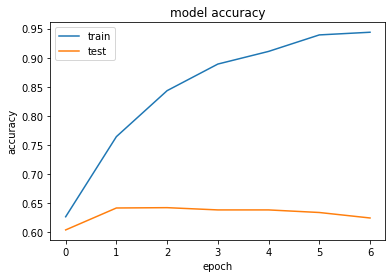

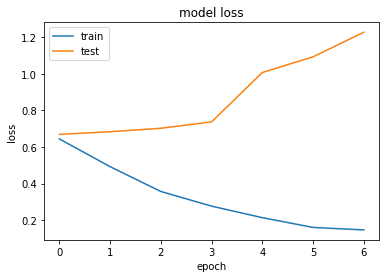

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
inp1 = Input(shape=(X_train.shape[1],))
x=Embedding(max_fatures, embed_dim,input_length = X_train.shape[1])(inp1)
# x = Embedding(vocab_size, 200, weights=[embedding_matrix])(inp1)
x = tf.keras.layers.Bidirectional(LSTM(256, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(LSTM(150))(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(64, activation="relu")(x)
x = Dense(2, activation="softmax")(x)    
model21 = Model(inputs=inp1, outputs=x)

print(model21.summary())
model21.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 67)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 67, 128)           640000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 67, 512)           788480    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 300)               795600    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               38528     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256

In [ ]:
batch_size = 64
model21.fit(X_train, Y_train, epochs = 25, batch_size=batch_size,validation_data=(X_test,Y_test), callbacks=[ earlystop, reduce_lr])

Epoch 1/25
79/79 [==============================] - 105s 1s/step - loss: 0.6447 - accuracy: 0.6014 - val_loss: 0.6540 - val_accuracy: 0.6333
Epoch 2/25
79/79 [==============================] - 99s 1s/step - loss: 0.3718 - accuracy: 0.8420 - val_loss: 0.8001 - val_accuracy: 0.6422
Epoch 3/25
79/79 [==============================] - 99s 1s/step - loss: 0.1985 - accuracy: 0.9242 - val_loss: 0.8485 - val_accuracy: 0.6172
Epoch 4/25
79/79 [==============================] - 100s 1s/step - loss: 0.1181 - accuracy: 0.9597 - val_loss: 1.3328 - val_accuracy: 0.6211
Epoch 5/25
79/79 [==============================] - 99s 1s/step - loss: 0.0571 - accuracy: 0.9802 - val_loss: 1.6431 - val_accuracy: 0.6211
Epoch 6/25
79/79 [==============================] - 102s 1s/step - loss: 0.0357 - accuracy: 0.9884 - val_loss: 1.6111 - val_accuracy: 0.6183

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
Epoch 00006: early stopping


# Using CNN

In [ ]:
import pandas as pd
import numpy as np
from numpy import asarray
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pydotplus as pyd

import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, concatenate

In [ ]:
input_data = Input(shape=(100,), name='main_input')
# embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False)(input_data)

embedding_layer=Embedding(max_fatures, embed_dim,input_length = X_train.shape[1])(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)
out = Dense(2, activation='softmax')(dense)

model_01 = Model(inputs=[input_data], outputs=[out])

print(model_01.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 100)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 128)          256000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 97, 50)            25650     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 48, 50)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 46, 100)           15100     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 23, 100)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2300)              0   

In [ ]:
model_01.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [ ]:
batch_size = 128
history1=model_01.fit(X_train, Y_train, epochs = 25, batch_size=batch_size,validation_data=(X_test,Y_test), callbacks=[ earlystop, reduce_lr])

Epoch 1/25
40/40 [==============================] - 5s 117ms/step - loss: 0.6736 - accuracy: 0.5826 - val_loss: 0.6849 - val_accuracy: 0.5856
Epoch 2/25
40/40 [==============================] - 4s 109ms/step - loss: 0.5301 - accuracy: 0.7387 - val_loss: 0.6799 - val_accuracy: 0.6300
Epoch 3/25
40/40 [==============================] - 4s 106ms/step - loss: 0.3567 - accuracy: 0.8500 - val_loss: 0.7667 - val_accuracy: 0.6361
Epoch 4/25
40/40 [==============================] - 4s 108ms/step - loss: 0.2231 - accuracy: 0.9221 - val_loss: 0.9602 - val_accuracy: 0.6350
Epoch 5/25
40/40 [==============================] - 4s 107ms/step - loss: 0.0967 - accuracy: 0.9720 - val_loss: 1.2229 - val_accuracy: 0.6256
Epoch 6/25
40/40 [==============================] - 4s 107ms/step - loss: 0.0330 - accuracy: 0.9952 - val_loss: 1.4398 - val_accuracy: 0.6244
Epoch 7/25
40/40 [==============================] - 4s 108ms/step - loss: 0.0138 - accuracy: 0.9989 - val_loss: 1.6098 - val_accuracy: 0.6178

Epoch

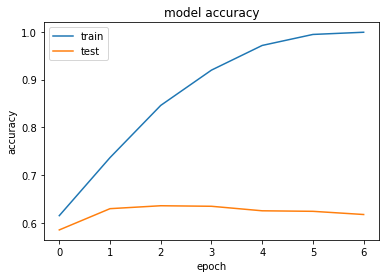

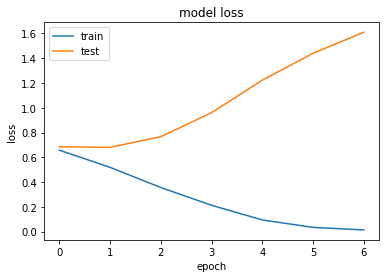

In [ ]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#using CNN-RNN

In [ ]:
input_data1 = Input(shape=(100,), name='main_input')
# embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False)(input_data)

embedding_layer11=Embedding(max_fatures, embed_dim,input_length = X_train.shape[1])(input_data1)
conv_11 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer11)
max_11 = MaxPooling1D(pool_size=2)(conv_11)
conv_21 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_11)
max_21 = MaxPooling1D(pool_size=2)(conv_21)
layer=LSTM(128, activation='sigmoid')(max_21)
flatten1 = Flatten()(layer)
dense1 = Dense(100, activation='relu', name='fully_connected')(flatten1)
out1 = Dense(2, activation='softmax')(dense1)

model_02 = Model(inputs=[input_data1], outputs=[out1])

print(model_02.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 100)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 128)          256000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 97, 50)            25650     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 48, 50)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 46, 100)           15100     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 23, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               1172

In [ ]:
model_02.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [ ]:
batch_size = 128
history2=model_02.fit(X_train, Y_train, epochs = 25, batch_size=batch_size,validation_data=(X_test,Y_test), callbacks=[ earlystop, reduce_lr])

Epoch 1/25
40/40 [==============================] - 10s 199ms/step - loss: 0.7064 - accuracy: 0.4880 - val_loss: 0.6852 - val_accuracy: 0.5683
Epoch 2/25
40/40 [==============================] - 7s 187ms/step - loss: 0.6297 - accuracy: 0.6595 - val_loss: 0.6668 - val_accuracy: 0.6144
Epoch 3/25
40/40 [==============================] - 7s 187ms/step - loss: 0.4659 - accuracy: 0.7809 - val_loss: 0.7291 - val_accuracy: 0.6094
Epoch 4/25
40/40 [==============================] - 7s 185ms/step - loss: 0.3197 - accuracy: 0.8725 - val_loss: 0.8274 - val_accuracy: 0.6111
Epoch 5/25
40/40 [==============================] - 7s 186ms/step - loss: 0.1819 - accuracy: 0.9453 - val_loss: 1.1610 - val_accuracy: 0.6011
Epoch 6/25
40/40 [==============================] - 7s 187ms/step - loss: 0.0864 - accuracy: 0.9780 - val_loss: 1.3696 - val_accuracy: 0.6117

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
Epoch 00006: early stopping


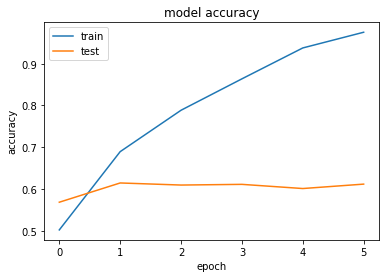

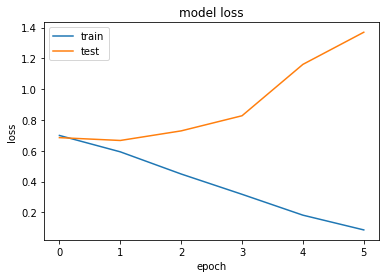

In [ ]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()